In [ ]:
%matplotlib inline


# Principal Component Regression vs Partial Least Squares Regression

This example compares `Principal Component Regression
<https://en.wikipedia.org/wiki/Principal_component_regression>`_ (PCR) and
`Partial Least Squares Regression
<https://en.wikipedia.org/wiki/Partial_least_squares_regression>`_ (PLS) on a
toy dataset. Our goal is to illustrate how PLS can outperform PCR when the
target is strongly correlated with some directions in the data that have a
low variance.

PCR is a regressor composed of two steps: first,
:class:`~sklearn.decomposition.PCA` is applied to the training data, possibly
performing dimensionality reduction; then, a regressor (e.g. a linear
regressor) is trained on the transformed samples. In
:class:`~sklearn.decomposition.PCA`, the transformation is purely
unsupervised, meaning that no information about the targets is used. As a
result, PCR may perform poorly in some datasets where the target is strongly
correlated with *directions* that have low variance. Indeed, the
dimensionality reduction of PCA projects the data into a lower dimensional
space where the variance of the projected data is greedily maximized along
each axis. Despite them having the most predictive power on the target, the
directions with a lower variance will be dropped, and the final regressor
will not be able to leverage them.

PLS is both a transformer and a regressor, and it is quite similar to PCR: it
also applies a dimensionality reduction to the samples before applying a
linear regressor to the transformed data. The main difference with PCR is
that the PLS transformation is supervised. Therefore, as we will see in this
example, it does not suffer from the issue we just mentioned.


In [ ]:
print(__doc__)

Automatically created module for IPython interactive environment


## The data

We start by creating a simple dataset with two features. Before we even dive
into PCR and PLS, we fit a PCA estimator to display the two principal
components of this dataset, i.e. the two directions that explain the most
variance in the data.



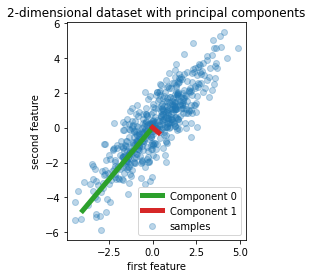

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 3],
       [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)


plt.scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

For the purpose of this example, we now define the target `y` such that it is
strongly correlated with a direction that has a small variance. To this end,
we will project `X` onto the second component, and add some noise to it.



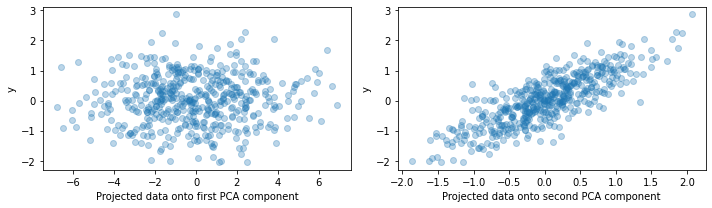

In [ ]:
y = X.dot(pca.components_[1]) + rng.normal(size=n_samples) / 2

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(X.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel='Projected data onto first PCA component', ylabel='y')
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel='Projected data onto second PCA component', ylabel='y')
plt.tight_layout()
plt.show()

## Projection on one component and predictive power

We now create two regressors: PCR and PLS, and for our illustration purposes
we set the number of components to 1. Before feeding the data to the PCA step
of PCR, we first standardize it, as recommended by good practice. The PLS
estimator has built-in scaling capabilities.

For both models, we plot the projected data onto the first component against
the target. In both cases, this projected data is what the regressors will
use as training data.



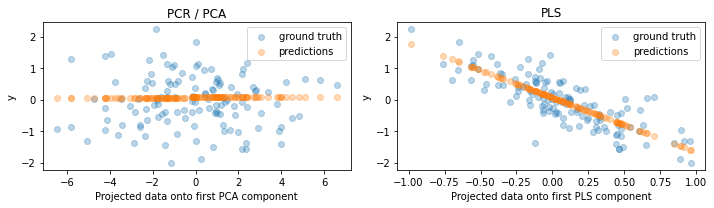

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
plt.tight_layout()
plt.show()

As expected, the unsupervised PCA transformation of PCR has dropped the
second component, i.e. the direction with the lowest variance, despite
it being the most predictive direction. This is because PCA is a completely
unsupervised transformation, and results in the projected data having a low
predictive power on the target.

On the other hand, the PLS regressor manages to capture the effect of the
direction with the lowest variance, thanks to its use of target information
during the transformation: it can recogize that this direction is actually
the most predictive. We note that the first PLS component is negatively
correlated with the target, which comes from the fact that the signs of
eigenvectors are arbitrary.

We also print the R-squared scores of both estimators, which further confirms
that PLS is a better alternative than PCR in this case. A negative R-squared
indicates that PCR performs worse than a regressor that would simply predict
the mean of the target.



In [ ]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared -0.026
PLS r-squared 0.658


As a final remark, we note that PCR with 2 components performs as well as
PLS: this is because in this case, PCR was able to leverage the second
component which has the most preditive power on the target.



In [ ]:
pca_2 = make_pipeline(PCA(n_components=2), LinearRegression())
pca_2.fit(X_train, y_train)
print(f"PCR r-squared with 2 components {pca_2.score(X_test, y_test):.3f}")

PCR r-squared with 2 components 0.673
